In [8]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [9]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') #includes y1 + sv3 for both stellar mass surveys

# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [10]:
#all sga ids used for rotation curves after 2d Vmap VI

good_sga = [9769, 11977, 12892, 14501, 16383, 19235, 19278, 25532, 30149, 31220, 32484, 36904, 37543, 46327, 58617, 73111, 88963, 91660, 90791, 106536, 
           114405, 114489, 122580, 126630, 125611, 128163, 128411, 130766, 149502, 153504, 175220, 176736, 184044, 186239, 189685, 188525, 190308, 
           192158, 196470, 199038, 202236, 205028, 209429, 212382, 218773, 235556, 254532, 272164, 272562, 276638, 288715, 289743, 291766, 300446, 
           302062, 305831, 309378, 319942, 330678, 349027, 349346, 363344, 373692, 378842, 384420, 389177, 393190, 395070, 398443, 398532, 416531, 
           431242, 430161, 432294, 450689, 450566, 455486, 457147, 458798, 462867, 466872, 467582, 471327, 469868, 471893, 473436, 477805, 481956, 
           485800, 493017, 507499, 526710, 544419, 544810, 544799, 544943, 548724, 548848, 550458, 564440, 569298, 568664, 570086, 582248, 591927, 
           607528, 608015, 629144, 630029, 630390, 635043, 638386, 641578, 643231, 643845, 644940, 647966, 649753, 649960, 651096, 654469, 659599, 
           663463, 671301, 671533, 694525, 696291, 696345, 706579, 720480, 722142, 726854, 728327, 729726, 729754, 736449, 742167, 743030, 744650, 
           752683, 757313, 757166, 758123, 759261, 759003, 766672, 783693, 793633, 804643, 805225, 819754, 820598, 823301, 824225, 826809, 827949, 
           833961, 833981, 843065, 843126, 845052, 887433, 901663, 901980, 908818, 908978, 911046, 914975, 914909, 916161, 920806, 923400, 925923, 
           925354, 928810, 928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 971635, 975775, 972260, 977015, 976853, 979168, 978708, 
           989040, 989244, 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1026141, 1031898, 1033651, 1033344, 1050173, 1065602, 1073430, 
           1086934, 1087039, 1087374, 1090772, 1091806, 1096564, 1098043, 1103477, 1111824, 1117018, 1124386, 1143335, 1146354, 1161160, 1167691, 
           1171841, 1179377, 1184894, 1184912, 1186034, 1187240, 1188032, 1188617, 1188926, 1193015, 1191665, 1194588, 1194958, 1199020, 1199539, 
           1201319, 1203786, 1204237, 1206707, 1218166, 1219319, 1254154, 1264056, 1264591, 1267967, 1271477, 1271549, 1272700, 1273605, 1278144, 
           1281619, 1282407, 1285273, 1286710, 1289613, 1293967, 1301768, 1304908, 1335916, 1338866, 1345100, 1348956, 1349555, 1354266, 1355575, 
           1361363, 1361399, 1365519, 1365549, 1367137, 1368018, 1368443, 1374964, 1379143, 1405053, 1429680, 1434487]

print(len(good_sga))

277


In [11]:
#all galaxies originally in TF sample (pre-VI)
rot_curve_gals = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
len(rot_curve_gals)

#pre VI: 383 main survey, 1266 sv3, 350 in both

1299

In [12]:
#finding non-center targets for each
main_filtered = tf_mastertable[(tf_mastertable['SURVEY'] == 'main') & 
                                (tf_mastertable['SKY_FIBER_DIST_R26'] >= 0.1)]

sv3_filtered = tf_mastertable[(tf_mastertable['SURVEY'] == 'sv3') & 
                               (tf_mastertable['SKY_FIBER_DIST_R26'] >= 0.1)]

#put into arrays
main_filtered_sga_ids = np.array(main_filtered['SGA_ID'])
sv3_filtered_sga_ids = np.array(sv3_filtered['SGA_ID'])
rot_curve_gals_sga_ids = np.array(rot_curve_gals)
good_sga_array = np.array(good_sga)

#find sga ids in common
common_sga_ids = np.intersect1d(main_filtered_sga_ids, rot_curve_gals_sga_ids)
common_sga_ids_2 = np.intersect1d(sv3_filtered_sga_ids, rot_curve_gals_sga_ids)

final_common = np.intersect1d(common_sga_ids, good_sga_array)
final_common_2 = np.intersect1d(common_sga_ids_2, good_sga_array)

# num of galaxies from Y1 in rot curve final sample
print(len(final_common))
# num of galaxies from sv3 in rot curve final sample
print(len(final_common_2))
#num of galaxies from both in rot curve final sample
final_common_all = np.intersect1d(final_common, final_common_2)
print(len(final_common_all))

90
265
78


In [13]:
# finding center targets for each
main_filtered = tf_mastertable[(tf_mastertable['SURVEY'] == 'main') & 
                                (tf_mastertable['SKY_FIBER_DIST_R26'] <= 0.1)]

sv3_filtered = tf_mastertable[(tf_mastertable['SURVEY'] == 'sv3') & 
                               (tf_mastertable['SKY_FIBER_DIST_R26'] <= 0.1)]

#put into arrays
main_filtered_sga_ids = np.array(main_filtered['SGA_ID'])
sv3_filtered_sga_ids = np.array(sv3_filtered['SGA_ID'])
rot_curve_gals_sga_ids = np.array(rot_curve_gals)
good_sga_array = np.array(good_sga)

#find sga ids in common
common_sga_ids = np.intersect1d(main_filtered_sga_ids, rot_curve_gals_sga_ids)
common_sga_ids_2 = np.intersect1d(sv3_filtered_sga_ids, rot_curve_gals_sga_ids)

final_common = np.intersect1d(common_sga_ids, good_sga_array)
final_common_2 = np.intersect1d(common_sga_ids_2, good_sga_array)

# num of galaxies from Y1 in rot curve final sample
print(len(final_common))
# num of galaxies from sv3 in rot curve final sample
print(len(final_common_2))
#num of galaxies from both in rot curve final sample
final_common_all = np.intersect1d(final_common, final_common_2)
print(len(final_common_all))

152
262
137


In [14]:
#Number of galaxies w/ ANY observations in each survey
main_sga_ids = []
sv3_sga_ids = []

for sga_id in good_sga: #for sga id in rot curve sample
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id] #row = sga id

    if np.any(rows['SURVEY'] == 'main') and np.all(tf_mastertable['M_R26'] >= 0): 
        main_sga_ids.append(sga_id)
    
    elif np.any(rows['SURVEY'] == 'sv3'):
        sv3_sga_ids.append(sga_id)

#convert to arrays to use np.intersect1d
main_sga_ids = np.array(main_sga_ids)
sv3_sga_ids = np.array(sv3_sga_ids)

main_sga_ids = np.intersect1d(main_sga_ids, good_sga_array)
sv3_sga_ids = np.intersect1d(sv3_sga_ids, good_sga_array)

#number of galaxies w/ all observations in main
print(len(main_sga_ids)) 

#number of galaxies w/ all observations in sv3
print(len(sv3_sga_ids)) 

#check that common galaxies between both surveys = 0
common = np.intersect1d(main_sga_ids, sv3_sga_ids)
len(common)

163
114


0

In [15]:
# Number of galaxies with ANY observations in each survey
main_sga_ids = []
sv3_sga_ids = []

for sga_id in good_sga:  # For SGA_ID in the rotation curve sample
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]  # Get rows for this SGA_ID

    # Check if there is any 'main' survey observation and all have M_R26 >= 0
    if np.any(rows['SURVEY'] == 'main') and np.all(rows['M_R26'] >= 0): 
        main_sga_ids.append(sga_id)
    
    # Check if there is any 'sv3' survey observation and all have M_R26 >= 0
    elif np.any(rows['SURVEY'] == 'sv3') and np.all(rows['M_R26'] >= 0):
        sv3_sga_ids.append(sga_id)

# Convert to arrays to use np.intersect1d
main_sga_ids = np.array(main_sga_ids)
sv3_sga_ids = np.array(sv3_sga_ids)

# Intersect with good_sga_array to get final list of SGA_IDs
main_sga_ids = np.intersect1d(main_sga_ids, good_sga_array)
sv3_sga_ids = np.intersect1d(sv3_sga_ids, good_sga_array)

# Print the number of galaxies with any observations in each survey
print(len(main_sga_ids))  # Number of galaxies with any observations in 'main'

print(len(sv3_sga_ids))  # Number of galaxies with any observations in 'sv3'

# Check that common galaxies between both surveys = 0
common = np.intersect1d(main_sga_ids, sv3_sga_ids)
print(len(common))  # Should be 0

163
114
0


In [16]:
#Number of galaxies w/ ANY observations AND in provabgs for each survey
main_sga_ids_prova = []
sv3_sga_ids_prova = []

#check for provabgs sm in main
for sga_id in main_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.all(rows['M_STELLAR_PROVABGS'] > 0):
        main_sga_ids_prova.append(sga_id)

#check for provabgs sm in sv3
for sga_id in sv3_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.all(rows['M_STELLAR_PROVABGS'] > 0):
        sv3_sga_ids_prova.append(sga_id)

#convert to arrays
main_sga_ids_prova = np.array(main_sga_ids_prova)
sv3_sga_ids_prova = np.array(sv3_sga_ids_prova)

#number of galaxies in main with M_STELLAR_PROVABGS > 0
print(len(main_sga_ids_prova))

#number of galaxies in sv3 with M_STELLAR_PROVABGS > 0
print(len(sv3_sga_ids_prova))

142
111


In [17]:
#Number of galaxies w/ ALL observations in each survey
main_sga_ids_all = []
sv3_sga_ids_all = []

for sga_id in good_sga: #for sga id in rot curve sample
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id] #row = sga id

    if np.all(rows['SURVEY'] == 'main'): 
        main_sga_ids_all.append(sga_id)
    
    elif np.all(rows['SURVEY'] == 'sv3'):
        sv3_sga_ids_all.append(sga_id)

#convert to arrays to use np.intersect1d
main_sga_ids_all = np.array(main_sga_ids_all)
sv3_sga_ids_all = np.array(sv3_sga_ids_all)

main_sga_ids_all = np.intersect1d(main_sga_ids_all, good_sga_array)
sv3_sga_ids_all = np.intersect1d(sv3_sga_ids_all, good_sga_array)

print(len(main_sga_ids_all))
print(len(sv3_sga_ids_all))   

12
109


In [18]:
#Number of galaxies w/ ALL observations AND in provabgs for each survey
main_sga_ids_all = []
sv3_sga_ids_all = []

for sga_id in good_sga: #for sga id in rot curve sample
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id] #row = sga id

    if np.all(rows['SURVEY'] == 'main'): 
        main_sga_ids_all.append(sga_id)
    
    elif np.all(rows['SURVEY'] == 'sv3'):
        sv3_sga_ids_all.append(sga_id)

#convert to arrays to use np.intersect1d
main_sga_ids_all = np.array(main_sga_ids_all)
sv3_sga_ids_all = np.array(sv3_sga_ids_all)

main_sga_ids_all = np.intersect1d(main_sga_ids_all, good_sga_array)
sv3_sga_ids_all = np.intersect1d(sv3_sga_ids_all, good_sga_array)

main_sga_ids_prova = []
sv3_sga_ids_prova = []

#check for provabgs sm in main
for sga_id in main_sga_ids_all:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] > 0):
        main_sga_ids_prova.append(sga_id)

#check for provabgs sm in sv3
for sga_id in sv3_sga_ids_all:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] > 0):
        sv3_sga_ids_prova.append(sga_id)

#convert to arrays
main_sga_ids_prova = np.array(main_sga_ids_prova)
sv3_sga_ids_prova = np.array(sv3_sga_ids_prova)

#number of galaxies in main with M_STELLAR_PROVABGS > 0
print(len(main_sga_ids_prova))

#number of galaxies in sv3 with M_STELLAR_PROVABGS > 0
print(len(sv3_sga_ids_prova))

0
106


In [19]:
#Number of galaxies w/ ANY observations AND in provabgs for each survey
main_sga_ids_prova = []
sv3_sga_ids_prova = []

#check for provabgs sm in main
for sga_id in main_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.all(rows['M_STELLAR_PROVABGS'] > 0):
        main_sga_ids_prova.append(sga_id)

#check for provabgs sm in sv3
for sga_id in sv3_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.all(rows['M_STELLAR_PROVABGS'] > 0):
        sv3_sga_ids_prova.append(sga_id)

#convert to arrays
main_sga_ids_prova = np.array(main_sga_ids_prova)
sv3_sga_ids_prova = np.array(sv3_sga_ids_prova)

#number of galaxies in main with M_STELLAR_PROVABGS > 0
print(len(main_sga_ids_prova))

#number of galaxies in sv3 with M_STELLAR_PROVABGS > 0
print(len(sv3_sga_ids_prova))

142
111


In [20]:
#Number of galaxies w/ center observations for each survey
main_sga_ids_center = []
sv3_sga_ids_center = []

for sga_id in main_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['SKY_FIBER_DIST_R26'] <= 0.1):
        main_sga_ids_center.append(sga_id)

for sga_id in sv3_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['SKY_FIBER_DIST_R26'] <= 0.1):
        sv3_sga_ids_center.append(sga_id)

#convert to arrays
main_sga_ids_center = np.array(main_sga_ids_center)
sv3_sga_ids_center = np.array(sv3_sga_ids_center)

#num of galaxies w/ center in main
print(len(main_sga_ids_center))

#num of galaxies w/ center in sv3
print(len(sv3_sga_ids_center))

#check for common galaxies in both surveys (should be 0)
common_center = np.intersect1d(main_sga_ids_center, sv3_sga_ids_center)
print(len(common_center))

163
114
0


In [21]:
#Number of galaxies w/ center observations AND in provabgs for each survey
main_sga_ids_center_prova = []
sv3_sga_ids_center_prova = []

for sga_id in main_sga_ids_center:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] >= 0):
        main_sga_ids_center_prova.append(sga_id)

for sga_id in sv3_sga_ids_center:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] >= 0):
        sv3_sga_ids_center_prova.append(sga_id)

# Convert to arrays
main_sga_ids_center_prova = np.array(main_sga_ids_center_prova)
sv3_sga_ids_center_prova = np.array(sv3_sga_ids_center_prova)

# Number of galaxies in main with center observation and M_STELLAR_PROVABGS >= 0
print(len(main_sga_ids_center_prova))

# Number of galaxies in sv3 with center observation and M_STELLAR_PROVABGS >= 0
print(len(sv3_sga_ids_center_prova))

142
111


In [22]:
#Number of galaxies w/ center in one survey + targets in the other
main_sga_ids_center_other = []
sv3_sga_ids_center_other = []

#find sga ids w/ center observation in main but any target in sv3
for sga_id in main_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['SKY_FIBER_DIST_R26'] <= 0.1) and np.any(rows['SURVEY'] == 'sv3'):
        main_sga_ids_center_other.append(sga_id)

#find sga ids w/ center observation in sv3 but any target in main
for sga_id in sv3_sga_ids:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['SKY_FIBER_DIST_R26'] <= 0.1) and np.any(rows['SURVEY'] == 'main'):
        sv3_sga_ids_center_other.append(sga_id)

#convert to arrays
main_sga_ids_center_other = np.array(main_sga_ids_center_other)
sv3_sga_ids_center_other = np.array(sv3_sga_ids_center_other)

#mum of galaxies w/ center in main + target in sv3
print(len(main_sga_ids_center_other))

#num of galaxies w/ center in sv3 + target in main 
print(len(sv3_sga_ids_center_other))

151
0


In [23]:
# Number of galaxies with center in one survey and targets in the other AND in prova
main_sga_ids_center_other_prova = []
sv3_sga_ids_center_other_prova = []

# Find SGA IDs with center observation in main but any target in sv3, and M_STELLAR_PROVABGS > 0
for sga_id in main_sga_ids_center_other:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] > 0):
        main_sga_ids_center_other_prova.append(sga_id)

# Find SGA IDs with center observation in sv3 but any target in main, and M_STELLAR_PROVABGS > 0
for sga_id in sv3_sga_ids_center_other:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_PROVABGS'] > 0):
        sv3_sga_ids_center_other_prova.append(sga_id)

# Convert to arrays
main_sga_ids_center_other_prova = np.array(main_sga_ids_center_other_prova)
sv3_sga_ids_center_other_prova = np.array(sv3_sga_ids_center_other_prova)

# Number of galaxies with center in main and target in sv3, and M_STELLAR_PROVABGS > 0
print(len(main_sga_ids_center_other_prova))

# Number of galaxies with center in sv3 and target in main, and M_STELLAR_PROVABGS > 0
print(len(sv3_sga_ids_center_other_prova))


142
0


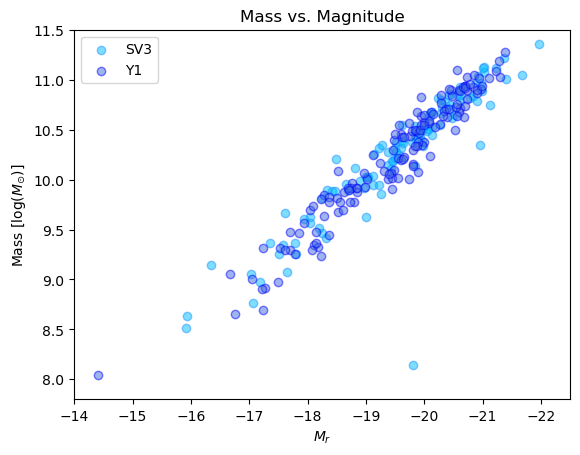

142
111


In [24]:
main_rows = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], main_sga_ids_prova) & (tf_mastertable['M_STELLAR_PROVABGS'] >= 0)]
sv3_rows = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], sv3_sga_ids_prova) & (tf_mastertable['M_STELLAR_PROVABGS'] >= 0)]

main_rows_unique = main_rows[np.unique(main_rows['SGA_ID'], return_index=True)[1]]
sv3_rows_unique = sv3_rows[np.unique(sv3_rows['SGA_ID'], return_index=True)[1]]

x = main_rows_unique['RABS_MAG26']
y = main_rows_unique['M_STELLAR_PROVABGS']

w = sv3_rows_unique['RABS_MAG26']
z = sv3_rows_unique['M_STELLAR_PROVABGS']

#plot!
plt.scatter(w, z, marker='o', color='deepskyblue', alpha=0.5, edgecolors='dodgerblue', label='SV3')
plt.scatter(x, y, marker='o', color='royalblue', alpha=0.5, edgecolors='blue', label='Y1')

plt.gca().invert_xaxis()
plt.ylim(7.8, 11.5)
plt.xlim(-14, -22.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")

plt.title("Mass vs. Magnitude")
plt.legend()

plt.show()

#num of each being plotted
print(len(main_rows_unique))
print(len(sv3_rows_unique))

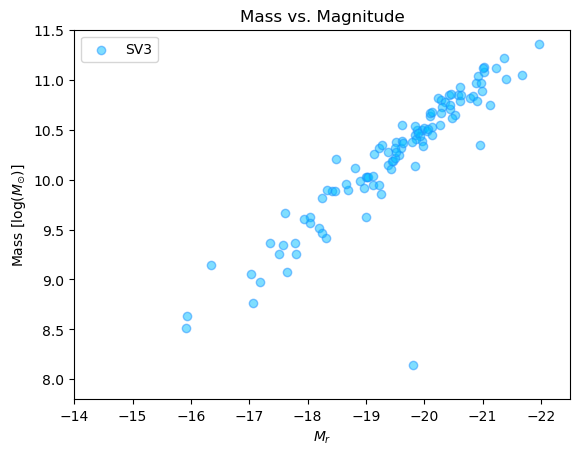

In [25]:
#plotting sv3 only
w = sv3_rows_unique['RABS_MAG26']
z = sv3_rows_unique['M_STELLAR_PROVABGS']

#plot!
plt.scatter(w, z, marker='o', color='deepskyblue', alpha=0.5, edgecolors='dodgerblue', label='SV3')

plt.gca().invert_xaxis()
plt.ylim(7.8, 11.5)
plt.xlim(-14, -22.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")

plt.title("Mass vs. Magnitude")
plt.legend()

plt.show()

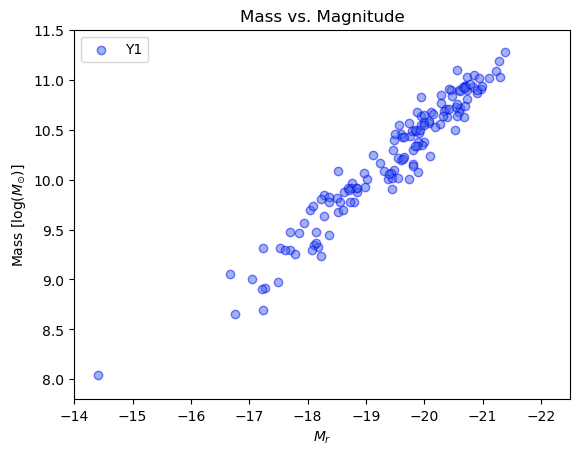

In [26]:
#Plotting Y1 only
x = main_rows_unique['RABS_MAG26']
y = main_rows_unique['M_STELLAR_PROVABGS']

#plot!
plt.scatter(x, y, marker='o', color='royalblue', alpha=0.5, edgecolors='blue', label='Y1')

plt.gca().invert_xaxis()
plt.ylim(7.8, 11.5)
plt.xlim(-14, -22.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")

plt.title("Mass vs. Magnitude")
plt.legend()

plt.show()

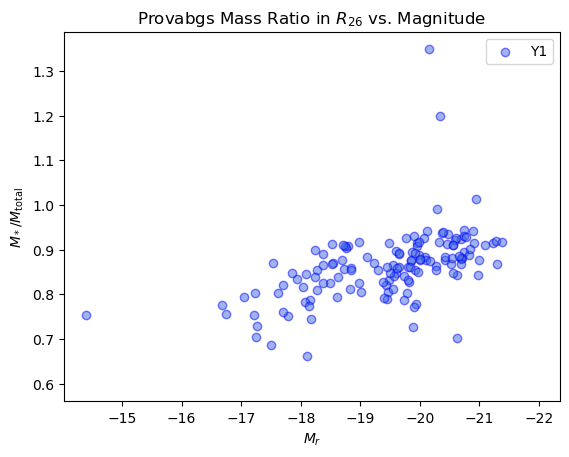

In [27]:
#ratio stellar mass to total mass within R26 using provabgs only
m_star_provabgs = main_rows_unique['M_STELLAR_PROVABGS']
mag = main_rows_unique['RABS_MAG26']
m_tot = main_rows_unique['M_R26']

ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_p, marker='o', color='royalblue', alpha=0.5, edgecolors='blue', label='Y1')
plt.gca().invert_xaxis()
plt.xlim(-14.023555877164437, -22.34887063853703)
plt.ylim(0.560713825939341, 1.3877213869586815)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

plt.title(r"Provabgs Mass Ratio in $R_{26}$ vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_y1_r26_mass_ratio_plot.png', dpi=300)
plt.show()

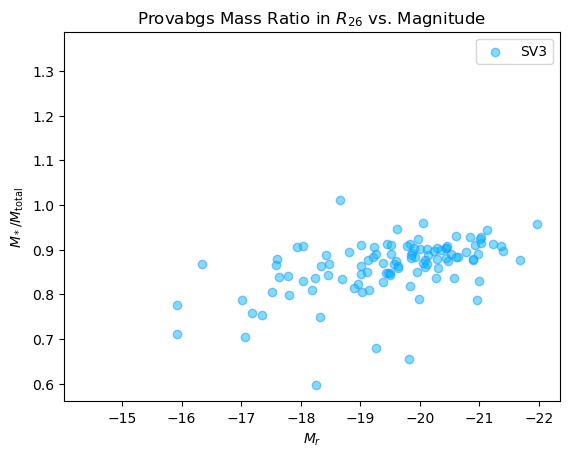

In [28]:
#ratio stellar mass to total mass within R26 using provabgs only
m_star_provabgs = sv3_rows_unique['M_STELLAR_PROVABGS']
mag = sv3_rows_unique['RABS_MAG26']
m_tot = sv3_rows_unique['M_R26']

ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_p, marker='o', color='deepskyblue', alpha=0.5, edgecolors='dodgerblue', label='SV3')
plt.gca().invert_xaxis()
plt.xlim(-14.023555877164437, -22.34887063853703)
plt.ylim(0.560713825939341, 1.3877213869586815)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

plt.title(r"Provabgs Mass Ratio in $R_{26}$ vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_y1_r26_mass_ratio_plot.png', dpi=300)
plt.show()

X-axis limits: (-14.023555877164437, -22.34887063853703)
Y-axis limits: (0.560713825939341, 1.3877213869586815)


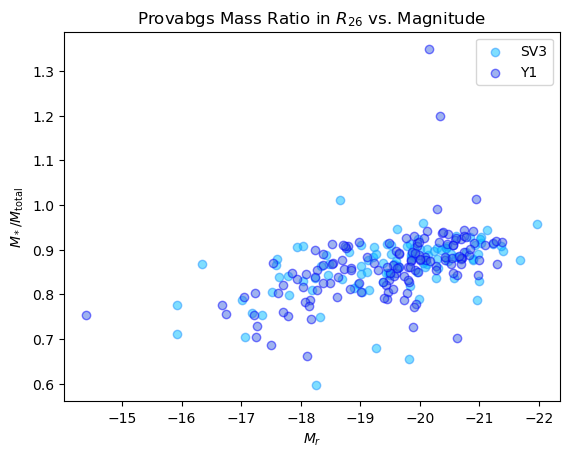

In [29]:
# Plot combined data

# For SV3 data
m_star_provabgs_sv3 = sv3_rows_unique['M_STELLAR_PROVABGS']
mag_sv3 = sv3_rows_unique['RABS_MAG26']
m_tot_sv3 = sv3_rows_unique['M_R26']
ratio_p_sv3 = 10 ** (np.log(m_star_provabgs_sv3) - np.log(m_tot_sv3))

# For Y1 data
m_star_provabgs_y1 = main_rows_unique['M_STELLAR_PROVABGS']
mag_y1 = main_rows_unique['RABS_MAG26']
m_tot_y1 = main_rows_unique['M_R26']
ratio_p_y1 = 10 ** (np.log(m_star_provabgs_y1) - np.log(m_tot_y1))

# Create a combined plot
plt.scatter(mag_sv3, ratio_p_sv3, marker='o', color='deepskyblue', alpha=0.5, edgecolors='dodgerblue', label='SV3')
plt.scatter(mag_y1, ratio_p_y1, marker='o', color='royalblue', alpha=0.5, edgecolors='blue', label='Y1')

# Invert the x-axis
plt.gca().invert_xaxis()

# Labeling
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")

x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

print(f"X-axis limits: {x_limits}")
print(f"Y-axis limits: {y_limits}")

# Title
plt.title(r"Provabgs Mass Ratio in $R_{26}$ vs. Magnitude")

# Add legend
plt.legend()

# Save and show the plot
plt.savefig(v_dir + 'provabgs_combined_r26_mass_ratio_plot.png', dpi=300)
plt.show()

In [30]:
x = main_rows_unique['M_STELLAR_PROVABGS']
y = main_rows_unique['M_R26']
z = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
#plt.savefig(v_dir + 'provabgs_stellar_total__mass_magplot.png', dpi=300)

NameError: name 'sgas' is not defined

In [33]:
#Number of galaxies w/ center observations AND in provabgs for each survey
main_sga_ids_center_cigale = []
sv3_sga_ids_center_cigale = []

for sga_id in main_sga_ids_center:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_CIGALE'] >= 0):
        main_sga_ids_center_cigale.append(sga_id)

for sga_id in sv3_sga_ids_center:
    rows = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    if np.any(rows['M_STELLAR_CIGALE'] >= 0):
        sv3_sga_ids_center_cigale.append(sga_id)

# Convert to arrays
main_sga_ids_center_cigale = np.array(main_sga_ids_center_cigale)
sv3_sga_ids_center_cigale = np.array(sv3_sga_ids_center_cigale)

#main_rows_unique_cigale = main_rows[np.unique(main_sga_ids_center_cigale['SGA_ID'], return_index=True)[1]]

# Number of galaxies in main with center observation and M_STELLAR_PROVABGS >= 0
print(len(main_sga_ids_center_cigale))

# Number of galaxies in sv3 with center observation and M_STELLAR_PROVABGS >= 0
print(len(sv3_sga_ids_center_cigale))

148
114


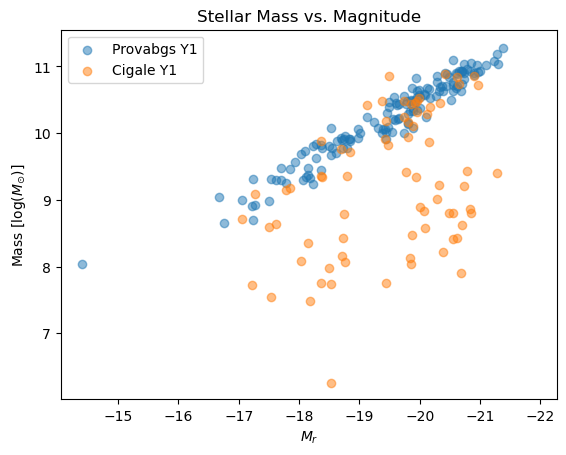

In [34]:
main_rows_unique_cigale = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], main_sga_ids_center_cigale)]
main_rows_unique_cigale = main_rows_unique_cigale[np.unique(main_rows_unique_cigale['SGA_ID'], return_index=True)[1]]

# Extract necessary data for plotting
x = main_rows_unique['RABS_MAG26']
y = main_rows_unique['M_STELLAR_PROVABGS']  # Provabgs stellar mass  

z = main_rows_unique_cigale['RABS_MAG26'] # R26 mass (total mass within R26)
w = main_rows_unique_cigale['M_STELLAR_CIGALE']  # Cigale stellar mass

# Plot
plt.scatter(x, y, marker='o', alpha = 0.5, label='Provabgs Y1')
plt.scatter(z, w,  marker='o', alpha = 0.5, label = 'Cigale Y1')

# Invert x-axis and set axis limits
plt.gca().invert_xaxis()

plt.xlim(-14.052735033167137, -22.2730993879439)
plt.ylim(6.0097013699993145, 11.550659316204507)
     
# Labels, title, and legend
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Stellar Mass vs. Magnitude")
plt.legend()

# Show plot
plt.show()


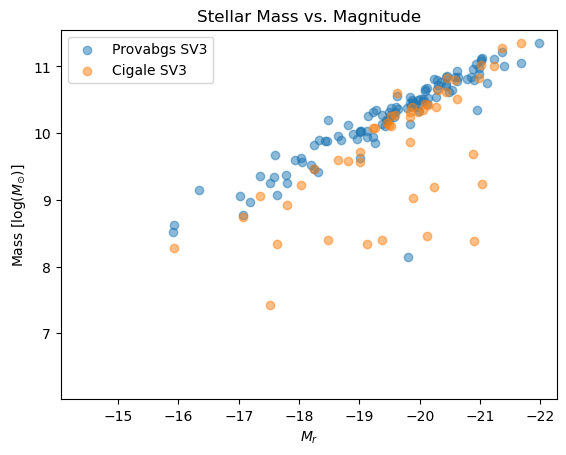

In [35]:
sv3_rows_unique_cigale = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], sv3_sga_ids_center_cigale)]
sv3_rows_unique_cigale = sv3_rows_unique_cigale[np.unique(sv3_rows_unique_cigale['SGA_ID'], return_index=True)[1]]

# Extract necessary data for plotting
x = sv3_rows_unique['RABS_MAG26']
y = sv3_rows_unique['M_STELLAR_PROVABGS']  # Provabgs stellar mass  

z = sv3_rows_unique_cigale['RABS_MAG26'] # R26 mass (total mass within R26)
w = sv3_rows_unique_cigale['M_STELLAR_CIGALE']  # Cigale stellar mass

# Plot
plt.scatter(x, y, marker='o', alpha = 0.5, label='Provabgs SV3')
plt.scatter(z, w,  marker='o', alpha = 0.5, label = 'Cigale SV3')

# Invert x-axis and set axis limits
plt.gca().invert_xaxis()

plt.xlim(-14.052735033167137, -22.2730993879439)
plt.ylim(6.0097013699993145, 11.550659316204507)

# Labels, title, and legend
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Stellar Mass vs. Magnitude")
plt.legend()

# Show plot
plt.show()

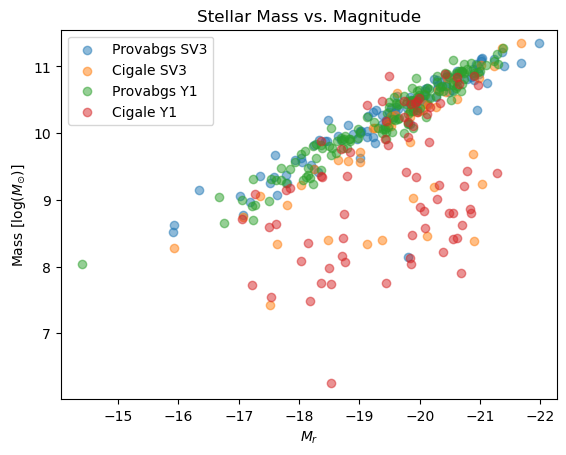

In [38]:
main_rows_unique_cigale = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], main_sga_ids_center_cigale)]
main_rows_unique_cigale = main_rows_unique_cigale[np.unique(main_rows_unique_cigale['SGA_ID'], return_index=True)[1]]

# Extract necessary data for plotting
x = main_rows_unique['RABS_MAG26']
y = main_rows_unique['M_STELLAR_PROVABGS']  # Provabgs stellar mass  

z = main_rows_unique_cigale['RABS_MAG26'] # R26 mass (total mass within R26)
w = main_rows_unique_cigale['M_STELLAR_CIGALE']  # Cigale stellar mass

sv3_rows_unique_cigale = tf_mastertable[np.isin(tf_mastertable['SGA_ID'], sv3_sga_ids_center_cigale)]
sv3_rows_unique_cigale = sv3_rows_unique_cigale[np.unique(sv3_rows_unique_cigale['SGA_ID'], return_index=True)[1]]

a = sv3_rows_unique['RABS_MAG26']
b = sv3_rows_unique['M_STELLAR_PROVABGS']  # Provabgs stellar mass  

c = sv3_rows_unique_cigale['RABS_MAG26'] # R26 mass (total mass within R26)
d = sv3_rows_unique_cigale['M_STELLAR_CIGALE']  # Cigale stellar mass

# Plot
plt.scatter(a, b, marker='o', alpha = 0.5, label='Provabgs SV3')
plt.scatter(c, d,  marker='o', alpha = 0.5, label = 'Cigale SV3')

plt.scatter(x, y, marker='o', alpha = 0.5, label='Provabgs Y1')
plt.scatter(z, w,  marker='o', alpha = 0.5, label = 'Cigale Y1')

# Invert x-axis and set axis limits
plt.gca().invert_xaxis()

plt.xlim(-14.052735033167137, -22.2730993879439)
plt.ylim(6.0097013699993145, 11.550659316204507)
     
# Labels, title, and legend
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Stellar Mass vs. Magnitude")
plt.legend()

# Show plot
plt.show()